<a href="https://colab.research.google.com/github/dormeir999/cities-classifier/blob/master/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & setup

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import requests
import zipfile
import glob
import os
from google.colab import drive
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import tensorflow as tf
from pathlib import Path
import glob
import numpy as np
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
path_model = '/content/gdrive/My Drive/adidas/02-model'
path_data =  '/content/gdrive/My Drive/adidas/01-data'
os.listdir(path_model) # test

['.ipynb_checkpoints',
 'weights',
 'logs',
 'model',
 'LeNet-Model',
 'tf image classification.ipynb',
 'Daniel Research Log.gdoc',
 'GAN']

In [ ]:
# colab output:
output_folder_path = '.'
output_folder_path = Path(output_folder_path)

# Load Data


In [ ]:
# get list of links from aws
map_links = pd.read_csv(
    'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/mapillary_links.csv'
    ,header=None).iloc[:,0].to_list()

In [ ]:
def download_url(url, save_path=False, chunk_size=128):
    "downloads zip files to the folder that the notebook / python file is saved"
    if not save_path:
        save_path = url.split('/')[-1]

    with requests.get(url, stream=True) as r:
        with open(save_path, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=chunk_size):
                fd.write(chunk)
    print(f"file {save_path} succesfuly downloaded")

    
def unzip_to_structure(zipfile_path, output_root_folder):
    """unzips files to specified output root folder with structure: 
        <output_root_folder> / <set_type> / <city> / <img_key>.jpg"""
    output_root_folder = Path(output_root_folder)
    file_parts = str(Path(zipfile_path).stem).split('_')
    city = file_parts[0]
    set_type = file_parts[1]
    for s in ['train','test','val']:   
      with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
        if set_type == s:
          zip_ref.extractall(output_root_folder / s )
    print(f"images from '{zipfile_path}' succesfuly unziped to '{output_root_folder / set_type / city}'")


def get_images(cities,output_path=output_folder_path,download_test=False):
  """gets all images for defined cities
  param:: cities, array of cities
  param:: output_path """
  linkz = []
  if not download_test:
    links = [l for l in map_links if 'test' not in l]
  else:
    links = map_links
  for city in cities:
    for link in links:
      if city in link:
        linkz.append(link) 
  # download files to current directory
  for link in linkz:
      download_url(link)
  # unzip images to destination with format: 
  # <output_root_folder> / <set_type> / <city> / <img_key>.jpg
  for link in linkz:
      filename = Path(link).name
      unzip_to_structure(filename,output_path)  

In [ ]:
# get data to current working dir (for changing dir got to top of the notebook):

# available cities:
my_cities = ['saopaulo','moscow','paris','manila','ottawa','austin','bangkok',
 'sf','phoenix','melbourne','tokyo','goa','toronto','berlin', 'budapest',
 'cph','helsinki','boston','amsterdam']

# city selection:
my_cities = ['saopaulo','paris','goa']

# download images from aws:
get_images(my_cities,download_test=True) 

file saopaulo_train.zip succesfuly downloaded
file saopaulo_val.zip succesfuly downloaded
file saopaulo_test.zip succesfuly downloaded
file paris_train.zip succesfuly downloaded
file paris_val.zip succesfuly downloaded
file paris_test.zip succesfuly downloaded
file goa_train.zip succesfuly downloaded
file goa_val.zip succesfuly downloaded
file goa_test.zip succesfuly downloaded
images from 'saopaulo_train.zip' succesfuly unziped to 'train/saopaulo'
images from 'saopaulo_val.zip' succesfuly unziped to 'val/saopaulo'
images from 'saopaulo_test.zip' succesfuly unziped to 'test/saopaulo'
images from 'paris_train.zip' succesfuly unziped to 'train/paris'
images from 'paris_val.zip' succesfuly unziped to 'val/paris'
images from 'paris_test.zip' succesfuly unziped to 'test/paris'
images from 'goa_train.zip' succesfuly unziped to 'train/goa'
images from 'goa_val.zip' succesfuly unziped to 'val/goa'
images from 'goa_test.zip' succesfuly unziped to 'test/goa'


In [ ]:
def get_data_to_numpy(file_list):
    X = []
    for filename in file_list :
        img = img_to_array(load_img(filename, target_size = (150,150)))
        X.append(img)
    X = np.array(X).astype('float32')
    # X = (X - X.mean()) / X.mean()
    X = X / 255
    return X

import glob
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

train_filelist = glob.glob('./train/*/*')
val_filelist = glob.glob('./val/*/*')
test_filelist = glob.glob('./train/*/*')
len(train_filelist), len(val_filelist), len(test_filelist)

#X_train = get_data(train_filelist)
#X_val = get_data(val_filelist)
#X_test = get_data(test_filelist)

(16966, 6516, 16966)

# Image Preprocessing

In [ ]:
import os
import tensorflow as tf
from pathlib import Path
import glob
import numpy as np
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Remove Outliers
Some helpr functions:

In [ ]:
# I changed some layers here so that the final output will have the same output size as our images - 150x150x3

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

def decode_images_using_existing_model_weights(dataset,weights_path = '/weights/Auto-Encoders.ckpt'):
  """Recives a numpy dataset, returns a decoded dataset using the pre-trained 
  auto-enocder weights"""
  # Create the CV for decoding
  input_img = Input(shape=(150, 150, 3))  # adapt this if using `channels_first` image data format
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  #x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)
  # at this point the representation is (4, 4, 8) i.e. 128-dimensional
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu')(x)
  #x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')#, metrics=['accuracy'])
  autoencoder.summary()

  # load weights
  checkpoint_filepath = path_model + weights_path
  autoencoder.load_weights(checkpoint_filepath)
  return autoencoder.predict(dataset)

def clean_dataset_from_outlier(dataset, decoded_dataset, outlier_threshold=0.99):
  """Receives the origionl and the autoencoded numpy dataset, return cleaned dataset
  without (default) 1% of images which are least similair to their decoded
  image, and the indices for the outliers."""
  squred_error = np.power(X_train - decoded_dataset, 2)
  channel_ax = 3
  width_ax = 1
  height_ax = 1
  mse = np.mean(np.mean(squred_error,axis=(channel_ax,width_ax)),axis=height_ax)
  mse_anomally_threshold = np.quantile(mse, outlier_threshold)
  outliers_idx = np.where(mse > mse_anomally_threshold)
  inliners_idx = np.where(mse <= mse_anomally_threshold)
  return dataset[inliners_idx], outliers_idx[0]

def show_origional_and_decoded(origional,decoded, n=5, show_decoded=True):
  'Show random n images and their decoded images'
  n+=1
  images_index = np.random.choice(len(origional),n)
  plt.figure(figsize=(20, 5))
  for i in range(1,n):
      ax = plt.subplot(1, n, i)
      plt.imshow(origional[images_index[i]])
      #plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

  plt.figure(figsize=(20, 5))

  if show_decoded:
    for i in range(1,n):
        ax = plt.subplot(1, n, i)
        plt.imshow(decoded[images_index[i]])
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Using TensorFlow backend.


* Uncomment the last line for cleaning a numpy dataset of images from outliers (using a threshold of percentage of outliers images).
* Uncomment the two lines before for getting the decoded datasets - more gerneralized form of the photos, which might remove outliers pixels.

In [ ]:
def remove_outliers(numpy_dataset, outlier_threshold=0.99):
  'Recievs a numpy dataset, return the cleand dataset and the indices of outliers'
  decoded_imgs = decode_images_using_existing_model_weights(numpy_dataset)
  cleaned_dataset, outliers_idx = clean_dataset_from_outlier(numpy_dataset, decoded_imgs,outlier_threshold=0.98)
  return cleaned_dataset, outliers_idx

#decoded_imgs = decode_images_using_existing_model_weights(X_train)
#show_origional_and_decoded(X_train,decoded_imgs, n=5)

#X_train_cleaned, outlier_idx = remove_outliers(X_train, outlier_threshold=0.99)

## Set image and batch size

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 1024

In [ ]:
train_dir = Path("./train")
val_dir = Path("./val")
test_dir = Path("./test")

In [ ]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*')])
CLASS_NAMES

array(['paris', 'goa', 'saopaulo'], dtype='<U8')

In [ ]:
train_image_count = len(list(train_dir.glob('*/*.jpg')))
val_image_count = len(list(val_dir.glob('*/*.jpg')))
test_image_count = len(list(test_dir.glob('*/*.jpg')))
train_image_count, val_image_count, test_image_count

(16966, 6516, 6518)

## Cached processing \ tf.data.Dataset

In [ ]:
list_train = tf.data.Dataset.list_files(str(train_dir/"*/*"))
list_val = tf.data.Dataset.list_files(str(val_dir/"*/*"))
list_test = tf.data.Dataset.list_files(str(test_dir/"*/*"),shuffle=False)


<TensorSliceDataset shapes: (), types: tf.string>

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [ ]:
# Use Dataset.map to create a dataset of image, label pairs:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_train = list_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_val = list_val.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_test = list_test.map(process_path, num_parallel_calls=AUTOTUNE)

train_dataset = prepare_for_training(labeled_train)
val_dataset = prepare_for_training(labeled_val)
test_dataset = prepare_for_training(labeled_test)

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.bool)>

## Augmentation attempt

In [ ]:
def flip(img,lbl):

  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_flip_up_down(img)
  choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
  return img,lbl


def color(img,lbl):

    img = tf.image.random_hue(img, 0.08)
    img = tf.image.random_saturation(img, 0.6, 1.6)
    img = tf.image.random_brightness(img, 0.05)
    img = tf.image.random_contrast(img, 0.7, 1.3)
    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    return img,lbl


def rotate(img,lbl):
  img = tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
  choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
  return img ,lbl


def zoom(img,lbl):

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(32, 32))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < .25, lambda: img, lambda: random_crop(img)),lbl


def clip(img,lbl):
  img = tf.clip_by_value(img, 0, 1)
  return img,lbl

In [ ]:
# augmentations = [flip, color, zoom, rotate]

# # Add the augmentations to the dataset
# for f in augmentations:
#     augmented_train = labeled_train.map(f, num_parallel_calls=AUTOTUNE)

# # Make sure that the values are still in [0, 1]
# augmented_train = augmented_train.map(clip, num_parallel_calls=AUTOTUNE)

# train_dataset = prepare_for_training(augmented_train)

# Build, complie & train

## Initialize VGG16

In [ ]:
# get train and test data:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="train",target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="test", target_size=(224,224))


Found 16966 images belonging to 3 classes.
Found 6518 images belonging to 3 classes.


TypeError: ignored

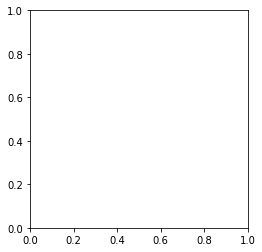

In [ ]:
plt.imshow(testdata[1][0])

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten

loaded_model = VGG16(weights='imagenet', include_top=True,
              input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

vgg16 = Sequential()
vgg16.add(loaded_model)
vgg16.add(Flatten())
vgg16.add(Dense(units=4096,activation="relu"))
vgg16.add(Dense(units=4096,activation="relu"))
vgg16.add(Dense(units=3, activation="softmax"))


vgg16.summary()

553467904/553467096 [==============================] - 9s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1000)              138357544 
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              4100096   
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12291     
Total params: 159,251,243
Trainable params: 159,251,243
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy",
)
from tensorflow.keras.optimizers import Adam
import tensorflow
opt = Adam(lr=0.001)
vgg16.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("gdrive/My Drive/adidas/02-model/weights/vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=4)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')
hist = vgg16.fit_generator(steps_per_epoch=100,
                           generator=traindata, 
                           validation_data= testdata, 
                           validation_steps=10,
                           epochs=100,
                           callbacks=[checkpoint,early])

Epoch 1/100
100/100 [==============================] - 87s 865ms/step - loss: 1.0944 - accuracy: 0.3853 - val_loss: 1.1120 - val_accuracy: 0.2375
Epoch 2/100
100/100 [==============================] - 86s 864ms/step - loss: 1.0949 - accuracy: 0.3759 - val_loss: 1.1061 - val_accuracy: 0.3125
Epoch 3/100
100/100 [==============================] - 86s 865ms/step - loss: 1.0952 - accuracy: 0.3797 - val_loss: 1.1118 - val_accuracy: 0.2594
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 1.0941 - accuracy: 0.3791
Epoch 00004: val_loss improved from inf to 1.11387, saving model to gdrive/My Drive/adidas/02-model/weights/vgg16_1.h5
100/100 [==============================] - 145s 1s/step - loss: 1.0941 - accuracy: 0.3791 - val_loss: 1.1139 - val_accuracy: 0.2812
Epoch 5/100
100/100 [==============================] - 87s 865ms/step - loss: 1.0942 - accuracy: 0.3816 - val_loss: 1.1074 - val_accuracy: 0.2812
Epoch 6/100
100/100 [==============================] - 88s 876ms/ste

In [ ]:
print("[INFO] compiling model...")
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
metrics = ["accuracy"]
loss = "categorical_crossentropy"

# build model:
model = LeNet().build(numChannels=3, 
                      imgRows=IMG_HEIGHT, 
                      imgCols=IMG_WIDTH, 
                      numClasses=len(CLASS_NAMES))


# compile model:
model.compile(loss=loss, optimizer=opt, metrics=metrics)

print("[INFO] compiling DONE")
model.summary()

[INFO] compiling model...


ValueError: ignored

## Setup model prerequisites

In [ ]:
# set callback:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,verbose=1)

checkpoint_filepath = path_model + '/weights/CNN-03.ckpt'
model_cp_cb = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)
checkpoint_filepath

'/content/gdrive/My Drive/adidas/02-model/weights/CNN-03.ckpt'

In [ ]:
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)
VAL_STEPS = np.ceil(val_image_count/BATCH_SIZE)

In [ ]:
# # Evaluate the model before training
# loss, acc = model.evaluate(train_dataset, verbose=1,steps=STEPS_PER_EPOCH)
# print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

17/17 [==============================] - 25s 1s/step - loss: 1.0865 - accuracy: 0.3747
Untrained model, accuracy: 37.47%


In [ ]:
# Setup Tensorboard - change from INACTIVE to Scalars after fit is done with the first epoch
# It will update thrhought the training
logdir = "./logs"
!rm -rf ./logs
%load_ext tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1)
%tensorboard --logdir "{logdir}"

# Train 🚂

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3,verbose=1)

history = model.fit(train_dataset, steps_per_epoch=STEPS_PER_EPOCH,
          epochs=20, 
          verbose=1, 
          validation_data=val_dataset,validation_steps=VAL_STEPS,
          callbacks=[model_cp_cb,tensorboard_callback,es_callback])

Epoch 1/20
17/17 [==============================] - 15s 880ms/step - loss: 1.0406 - accuracy: 0.5149 - val_loss: 0.7224 - val_accuracy: 0.7121
Epoch 2/20
17/17 [==============================] - 3s 158ms/step - loss: 0.5420 - accuracy: 0.7852 - val_loss: 0.5007 - val_accuracy: 0.8131
Epoch 3/20
17/17 [==============================] - 3s 166ms/step - loss: 0.3351 - accuracy: 0.8793 - val_loss: 0.3981 - val_accuracy: 0.8620
Epoch 4/20
17/17 [==============================] - 3s 159ms/step - loss: 0.2286 - accuracy: 0.9210 - val_loss: 0.3900 - val_accuracy: 0.8763
Epoch 5/20
17/17 [==============================] - 3s 168ms/step - loss: 0.1722 - accuracy: 0.9397 - val_loss: 0.3701 - val_accuracy: 0.8785
Epoch 6/20
17/17 [==============================] - 2s 145ms/step - loss: 0.1322 - accuracy: 0.9551 - val_loss: 0.4158 - val_accuracy: 0.8753
Epoch 7/20
17/17 [==============================] - 2s 145ms/step - loss: 0.1057 - accuracy: 0.9644 - val_loss: 0.4639 - val_accuracy: 0.8645
Epoch

# Evaluate model on test set

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Get y_true and y_pred
X_true = np.array([l[0].numpy() for l in list(labeled_test)])
Y_true = np.array([list(l[1].numpy()) for l in list(labeled_test)])
y_true = np.argmax(Y_true,axis=1)
Y_pred = model.predict(np.array(X_true),verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

204/204 [==============================] - 1s 3ms/step


In [ ]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

Classification Report
              precision    recall  f1-score   support

    saopaulo       0.77      0.91      0.84      1771
         goa       0.98      0.88      0.93      2427
       paris       0.92      0.88      0.90      2320

    accuracy                           0.89      6518
   macro avg       0.89      0.89      0.89      6518
weighted avg       0.90      0.89      0.89      6518



Confusion Matrix


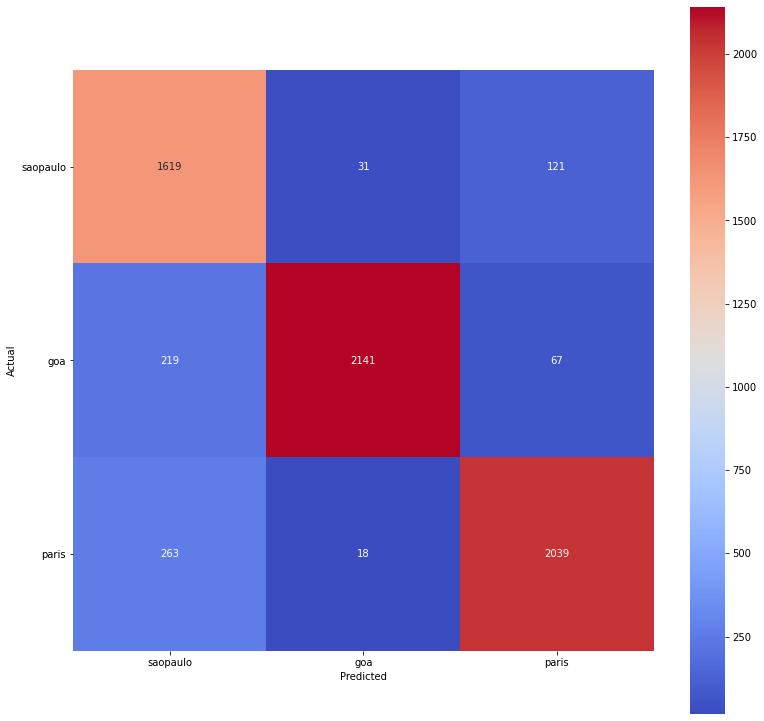

In [ ]:

print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(13,13))
sns.heatmap(cm, annot=True, fmt='g',cmap = 'coolwarm',square=True,xticklabels=CLASS_NAMES,yticklabels=CLASS_NAMES)
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual');

# Attempt at generalization

1/1 [==============================] - 0s 1ms/step


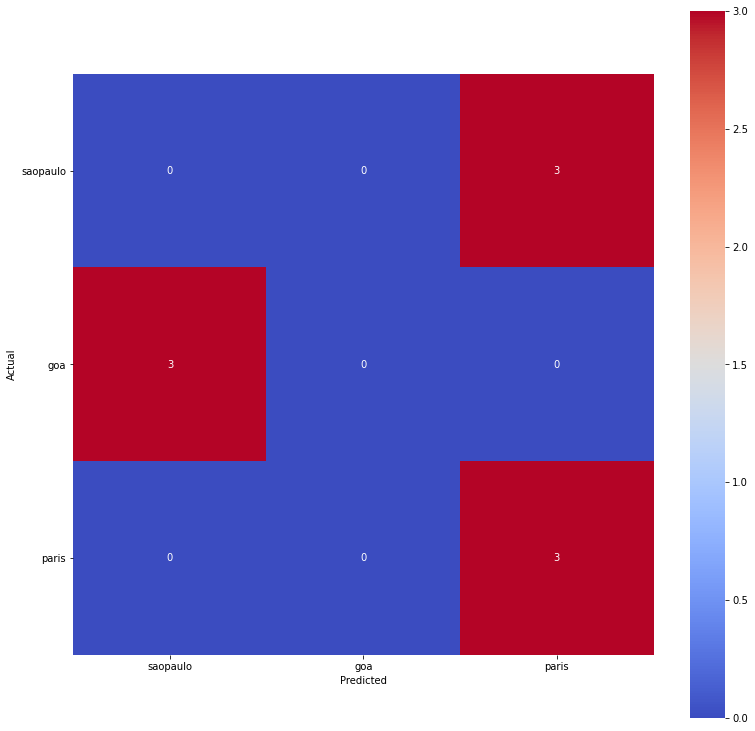

In [ ]:
# Setup generalization dataset (from drive)
gen_dir = Path(path_data+'/generalization/')
list_gen = tf.data.Dataset.list_files(str(gen_dir/"*/*"),shuffle=False)
labeled_gen = list_gen.map(process_path, num_parallel_calls=AUTOTUNE)
gen_dataset = prepare_for_training(labeled_gen)

# Get y_true and y_pred
X_true = np.array([l[0].numpy() for l in list(labeled_gen)])
Y_true = np.array([list(l[1].numpy()) for l in list(labeled_gen)])
y_true = np.argmax(Y_true,axis=1)
Y_pred = model.predict(np.array(X_true),verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(13,13))
sns.heatmap(cm, annot=True, fmt='g',cmap = 'coolwarm',square=True,xticklabels=CLASS_NAMES,yticklabels=CLASS_NAMES)
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

In [ ]:
def get_data(file_list,norm_range=[-1,1],img_size=(128,128)):
    X = []
    for filename in file_list :
        img = img_to_array(load_img(filename, target_size = img_size))
        X.append(img)
    X = np.array(X).astype('float32')
    if norm_range == [-1,1]:
      X = (X - X.mean()) / X.std()
      X = np.clip(X,-1,1)
    elif norm_range == [0,1]:
      X = X / 255
    else:
      print('bad range')
      return
    return X,X.mean(),X.std()

In [ ]:
paris_files = glob.glob('./train/paris/*')

In [ ]:
dataset,mean,std = get_data(paris_files)

In [ ]:
dataset.min(),dataset.max()

(-1.0, 1.0)

In [ ]:
# (X - X.mean()) / X.std()

im = dataset[2]

plt.imshow(im*im.std() + im.mean());


NameError: ignored